In [41]:
from ortools.sat.python import cp_model
from collections import namedtuple

class Machine_Parallele:
    """
    Classe pour résoudre le problème d'ordonnancement sur machines parallèles non-reliées.
    Utilise le solveur CP-SAT de OR-Tools pour optimiser l'affectation des tâches aux machines.
    """
    
    def __init__(self, taskInfo, tasks, machines):
        """
        Initialise le modèle d'ordonnancement.
        
        Paramètres:
            taskInfo: namedtuple définissant la structure des tâches
            tasks: dictionnaire des tâches {nom: taskInfo(duration, successors, release_date, due_date)}
            machines: liste des machines disponibles
        """
        self.taskInfo = taskInfo
        self.tasks = tasks 
        self.machines = machines

        # Créer le modèle CP-SAT
        self.model = cp_model.CpModel()

        # Variables de décision: temps de début de chaque tâche
        # Domaine: [release_date, due_date - duration] pour respecter les contraintes temporelles
        self.start_time_vars = {
            task_name: self.model.new_int_var_from_domain(
                cp_model.Domain.from_intervals([[task_info.release_date, task_info.due_date - task_info.duration]]),
                f"start_{task_name}"
            )
            for task_name, task_info in self.tasks.items()
        }

        # Variables booléennes: affectation des tâches aux machines
        # machine_vars[task][machine] = 1 si la tâche est affectée à cette machine
        self.machine_vars = {
            task_name: {
                machine: self.model.new_bool_var(f"{task_name}_on_{machine}") 
                for machine in self.machines
            }
            for task_name in self.tasks
        }

        # Variables d'intervalle pour la contrainte de non-chevauchement
        # Chaque tâche a un intervalle optionnel pour chaque machine
        self.interval_vars = {
            task_name: {
                machine: self.model.new_optional_fixed_size_interval_var(
                    start=self.start_time_vars[task_name],
                    size=task_info.duration,
                    is_present=self.machine_vars[task_name][machine],
                    name=f"interval_{task_name}_on_{machine}"
                )
                for machine in self.machines
            }
            for task_name, task_info in self.tasks.items()
        }

        # CONTRAINTES
        
        # 1. Chaque tâche doit être affectée à exactement une machine
        for task_name, machine_dict in self.machine_vars.items():
            self.model.add_exactly_one(machine_dict.values())

        # 2. Non-chevauchement: les tâches sur la même machine ne peuvent pas se chevaucher
        for machine in self.machines:
            self.model.add_no_overlap([
                self.interval_vars[task_name][machine] 
                for task_name in self.tasks
            ])

        # 3. Contraintes de précédence: une tâche doit se terminer avant son successeur
        for task_name, task_info in self.tasks.items():
            if task_info.successors != "none":
                successor_name = task_info.successors
                task_end = self.start_time_vars[task_name] + task_info.duration
                # La tâche doit se terminer avant que son successeur ne commence
                self.model.Add(task_end <= self.start_time_vars[successor_name])

        # FONCTION OBJECTIF
        # Minimiser la somme des dates de début (optimise le makespan et la compacité)
        self.model.Minimize(
            sum(self.start_time_vars[task_name] for task_name in self.tasks)
        )
        
        # Résoudre le modèle
        self.solver = cp_model.CpSolver()
        self.status = self.solver.solve(self.model)

    def print_start_date(self):
        """Affiche les dates de début de chaque tâche."""
        if self.status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            for task_name in self.tasks:
                start_time = self.solver.value(self.start_time_vars[task_name])
                print(f"{task_name} starts at {start_time}")
            print(f"Objective Value: {self.solver.objective_value}")
        else:
            print("No feasible solution found.")
    
    def get_schedule(self):
        """
        Retourne l'ordonnancement complet sous forme de dictionnaire.
        
        Retour:
            dict: {task_name: {start, end, duration, machine, release_date, due_date, slack, successor}}
                  ou None si aucune solution n'est trouvée
        """
        if self.status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            return None
        
        schedule = {}
        for task_name, task_info in self.tasks.items():
            start = self.solver.value(self.start_time_vars[task_name])
            end = start + task_info.duration
            
            # Trouver la machine affectée à cette tâche
            assigned_machine = None
            for machine in self.machines:
                if self.solver.value(self.machine_vars[task_name][machine]):
                    assigned_machine = machine
                    break
            
            # Calculer le slack (marge avant la date d'échéance)
            slack = task_info.due_date - end
            
            schedule[task_name] = {
                'start': start,
                'end': end,
                'duration': task_info.duration,
                'machine': assigned_machine,
                'release_date': task_info.release_date,
                'due_date': task_info.due_date,
                'slack': slack,
                'successor': task_info.successors
            }
        
        return schedule
    
    def print_machine_assignments(self):
        """Affiche l'affectation des tâches aux machines."""
        if self.status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            print("No feasible solution found.")
            return
        
        print("\n=== Affectation des Tâches aux Machines ===")
        for machine in self.machines:
            tasks_on_machine = [
                task_name for task_name in self.tasks
                if self.solver.value(self.machine_vars[task_name][machine])
            ]
            print(f"{machine}: {', '.join(tasks_on_machine) if tasks_on_machine else 'Aucune tâche'}")
    
    def print_order(self):
        """Affiche les tâches dans l'ordre chronologique d'exécution."""
        if self.status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            print("No feasible solution found.")
            return
        
        schedule = self.get_schedule()
        if not schedule:
            return
        
        # Trier les tâches par date de début
        sorted_tasks = sorted(schedule.items(), key=lambda x: x[1]['start'])
        
        print("\n=== Ordre d'Exécution (Chronologique) ===")
        for task_name, info in sorted_tasks:
            print(f"{task_name}: Début={info['start']}, Fin={info['end']}, "
                  f"Machine={info['machine']}, Marge={info['slack']}")
    
    def get_machine_utilization(self):
        """
        Calcule les statistiques d'utilisation pour chaque machine.
        
        Retour:
            dict: {machine: {total_work_time, utilization_rate, idle_time}}
        """
        if self.status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            return None
        
        schedule = self.get_schedule()
        if not schedule:
            return None
        
        # Calculer le makespan (durée totale du projet)
        makespan = max(info['end'] for info in schedule.values())
        min_start = min(info['start'] for info in schedule.values())
        total_time = makespan - min_start
        
        utilization = {}
        for machine in self.machines:
            # Temps de travail total sur cette machine
            total_work_time = sum(
                info['duration'] for task_name, info in schedule.items()
                if info['machine'] == machine
            )
            
            utilization[machine] = {
                'total_work_time': total_work_time,
                'utilization_rate': (total_work_time / total_time * 100) if total_time > 0 else 0,
                'idle_time': total_time - total_work_time
            }
        
        return utilization
    
    def print_utilization(self):
        """Affiche les statistiques d'utilisation des machines."""
        utilization = self.get_machine_utilization()
        if not utilization:
            print("No feasible solution found.")
            return
        
        print("\n=== Utilisation des Machines ===")
        for machine, stats in utilization.items():
            print(f"{machine}:")
            print(f"  Temps de travail: {stats['total_work_time']} unités")
            print(f"  Temps d'inactivité: {stats['idle_time']} unités")
            print(f"  Taux d'utilisation: {stats['utilization_rate']:.2f}%")
    
    def get_critical_path(self):
        """
        Identifie les tâches critiques (avec peu ou pas de marge).
        
        Retour:
            dict: Tâches avec marge <= 5 unités
        """
        if self.status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            return None
        
        schedule = self.get_schedule()
        if not schedule:
            return None
        
        # Tâches critiques: celles avec une marge faible
        critical_tasks = {
            task_name: info for task_name, info in schedule.items()
            if info['slack'] <= 5
        }
        
        return critical_tasks
    
    def print_critical_tasks(self):
        """Affiche les tâches critiques (marge faible)."""
        critical = self.get_critical_path()
        if not critical:
            print("No feasible solution found.")
            return
        
        print("\n=== Tâches Critiques (Marge Faible) ===")
        if not critical:
            print("Aucune tâche critique trouvée.")
        else:
            for task_name, info in sorted(critical.items(), key=lambda x: x[1]['slack']):
                print(f"{task_name}: Marge={info['slack']}, "
                      f"Échéance={info['due_date']}, Fin={info['end']}")
    
    def get_makespan(self):
        """
        Retourne le makespan (durée totale du projet).
        
        Retour:
            int: Date de fin de la dernière tâche
        """
        if self.status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            return None
        
        schedule = self.get_schedule()
        if not schedule:
            return None
        
        return max(info['end'] for info in schedule.values())
    
    def print_summary(self):
        """Affiche un résumé complet de la solution d'ordonnancement."""
        if self.status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            print("Aucune solution réalisable trouvée.")
            return
        
        print("\n" + "="*60)
        print("RÉSUMÉ DE L'ORDONNANCEMENT")
        print("="*60)
        
        # Statut de la solution
        if self.status == cp_model.OPTIMAL:
            print("Statut: Solution OPTIMALE trouvée")
        else:
            print("Statut: Solution RÉALISABLE trouvée")
        
        # Makespan
        makespan = self.get_makespan()
        print(f"\nMakespan (Durée totale): {makespan} unités de temps")
        print(f"Valeur de l'objectif: {self.solver.objective_value}")
        
        # Afficher les détails
        self.print_machine_assignments()
        self.print_utilization()
        self.print_critical_tasks()
        self.print_order()
        
        print("\n" + "="*60)
    
    def export_to_dataframe(self):
        """
        Exporte l'ordonnancement vers un DataFrame pandas.
        
        Retour:
            pd.DataFrame: Ordonnancement avec toutes les informations
        """
        try:
            import pandas as pd
        except ImportError:
            print("pandas n'est pas installé. Installez-le avec: pip install pandas")
            return None
        
        schedule = self.get_schedule()
        if not schedule:
            return None
        
        df = pd.DataFrame.from_dict(schedule, orient='index')
        df.index.name = 'task'
        df = df.reset_index()
        
        return df
    
    def visualize_gantt(self):
        """
        Crée un diagramme de Gantt de l'ordonnancement.
        
        - Axe Y: Machines
        - Axe X: Temps
        - Couleurs: Les tâches du même projet ont la même couleur
        """
        try:
            import matplotlib.pyplot as plt  
            import matplotlib.patches as mpatches 
        except ImportError:
            print("matplotlib n'est pas installé. Installez-le avec: pip install matplotlib")
            return
        
        schedule = self.get_schedule()
        if not schedule:
            print("Aucune solution réalisable trouvée.")
            return
        
        # Palette de couleurs pour les projets
        colors = plt.cm.tab20(range(20))
        
        def get_project_name(task_name):
            """Extrait le nom du projet à partir du nom de la tâche (ex: task_a_1 -> task_a)."""
            parts = task_name.rsplit('_', 1)
            if len(parts) == 2 and parts[1].isdigit():
                return parts[0]
            return task_name
        
        # Assigner une couleur à chaque projet
        projects = list(set(get_project_name(task) for task in schedule.keys()))
        project_colors = {project: colors[i % 20] for i, project in enumerate(sorted(projects))}
        
        # Créer la figure
        fig, ax = plt.subplots(figsize=(14, max(6, len(self.machines) * 1.5)))
        
        # Grouper les tâches par machine
        machine_tasks = {machine: [] for machine in self.machines}
        for task_name, info in schedule.items():
            machine_tasks[info['machine']].append((task_name, info))
        
        # Dessiner le diagramme - une ligne par machine
        yticks = []
        yticklabels = []
        
        for machine_idx, machine in enumerate(self.machines):
            y_pos = machine_idx
            tasks = sorted(machine_tasks[machine], key=lambda x: x[1]['start'])
            
            for task_name, info in tasks:
                # Obtenir la couleur du projet
                project = get_project_name(task_name)
                task_color = project_colors[project]
                
                # Dessiner la barre de la tâche
                ax.barh(y_pos, info['duration'], left=info['start'], 
                       height=0.6, color=task_color, 
                       edgecolor='black', linewidth=1.5, alpha=0.85)
                
                # Ajouter le nom de la tâche au centre de la barre
                ax.text(info['start'] + info['duration']/2, y_pos, task_name, 
                       ha='center', va='center', fontsize=9, fontweight='bold',
                       color='white', bbox=dict(boxstyle='round,pad=0.3', 
                       facecolor='black', alpha=0.3, edgecolor='none'))
            
            yticks.append(y_pos)
            yticklabels.append(machine)
        
        # Configuration des axes
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, fontsize=11, fontweight='bold')
        ax.set_ylabel('Machines', fontsize=12, fontweight='bold')
        ax.set_xlabel('Temps', fontsize=12, fontweight='bold')
        ax.set_title('Diagramme de Gantt - Ordonnancement sur Machines Parallèles', 
                    fontsize=14, fontweight='bold')
        
        # Grille
        ax.grid(axis='x', alpha=0.4, linestyle='--')
        ax.set_axisbelow(True)
        
        # Limites de l'axe X
        max_time = max(info['end'] for info in schedule.values())
        ax.set_xlim(0, max_time * 1.05)
        
        # Légende des projets
        legend_patches = [
            mpatches.Patch(color=project_colors[proj], label=proj, alpha=0.85) 
            for proj in sorted(projects)
        ]
        ax.legend(handles=legend_patches, loc='upper right', fontsize=9, title='Projets')
        
        plt.tight_layout()
        plt.show()

In [42]:
# ============================================
# EXEMPLE 1: Ordonnancement Manuel
# ============================================

# Définir la structure des tâches
taskInfo = namedtuple("taskInfo", ["duration", "successors", "release_date", "due_date"])

# Définir les tâches - chaque projet a 2 tâches (task_x_1 -> task_x_2)
tasks = {
    # Projet A: task_a_1 doit se terminer avant task_a_2
    "task_a_1": taskInfo(
        duration=120,           # Durée: 120 unités
        successors="task_a_2",  # Successeur: task_a_2
        release_date=0,         # Disponible dès le début
        due_date=600            # Échéance
    ),
    "task_a_2": taskInfo(
        duration=20,
        successors="none",      # Pas de successeur
        release_date=0,
        due_date=600
    ),
    
    # Projet B
    "task_b_1": taskInfo(
        duration=120,
        successors="task_b_2",
        release_date=0,
        due_date=600
    ),
    "task_b_2": taskInfo(
        duration=120,
        successors="none",
        release_date=0,
        due_date=600
    ),
}

# Définir les machines disponibles
machines = ["m_a", "m_b"]

# Créer et résoudre le problème d'ordonnancement
Opti_1 = Machine_Parallele(taskInfo, tasks, machines)

# Afficher les dates de début
Opti_1.print_start_date()

task_a_1 starts at 0
task_a_2 starts at 120
task_b_1 starts at 0
task_b_2 starts at 120
Objective Value: 240.0



RÉSUMÉ DE L'ORDONNANCEMENT
Statut: Solution OPTIMALE trouvée

Makespan (Durée totale): 240 unités de temps
Valeur de l'objectif: 240.0

=== Affectation des Tâches aux Machines ===
m_a: task_a_2, task_b_1
m_b: task_a_1, task_b_2

=== Utilisation des Machines ===
m_a:
  Temps de travail: 140 unités
  Temps d'inactivité: 100 unités
  Taux d'utilisation: 58.33%
m_b:
  Temps de travail: 240 unités
  Temps d'inactivité: 0 unités
  Taux d'utilisation: 100.00%
No feasible solution found.

=== Ordre d'Exécution (Chronologique) ===
task_a_1: Début=0, Fin=120, Machine=m_b, Marge=480
task_b_1: Début=0, Fin=120, Machine=m_a, Marge=480
task_a_2: Début=120, Fin=140, Machine=m_a, Marge=460
task_b_2: Début=120, Fin=240, Machine=m_b, Marge=360



=== Dictionnaire de l'Ordonnancement ===
task_a_1: {'start': 0, 'end': 120, 'duration': 120, 'machine': 'm_b', 'release_date': 0, 'due_date': 600, 'slack': 480, 'successor': 'task_a_2'}
task_a_2: {'start': 120, 'end': 140, 'duration': 20, 'machine': 'm_a', 're

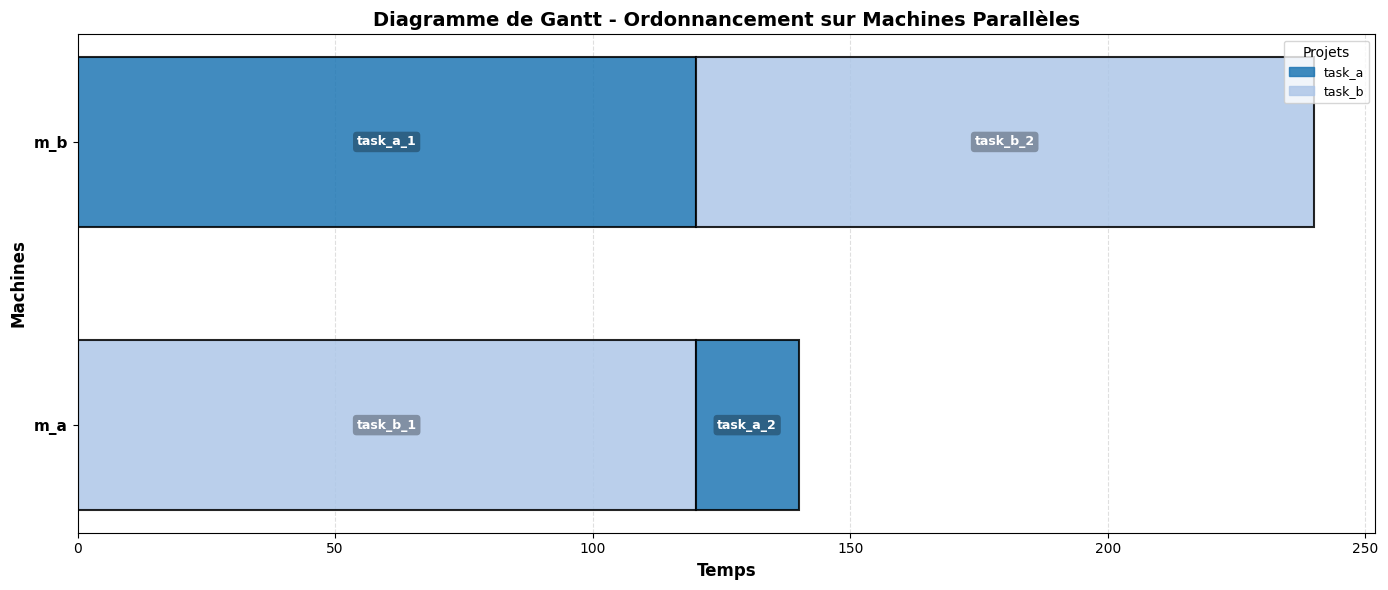

In [43]:
# ============================================
# ANALYSE DE LA SOLUTION
# ============================================

# 1. Résumé complet de l'ordonnancement
Opti_1.print_summary()

# 2. Récupérer l'ordonnancement sous forme de dictionnaire
print("\n\n=== Dictionnaire de l'Ordonnancement ===")
schedule_dict = Opti_1.get_schedule()
for task, info in schedule_dict.items():
    print(f"{task}: {info}")

# 3. Obtenir le makespan (durée totale du projet)
print(f"\n\nMakespan du Projet: {Opti_1.get_makespan()} unités de temps")

# 4. Exporter vers un DataFrame pandas (pour analyse approfondie)
print("\n\n=== DataFrame de l'Ordonnancement ===")
df = Opti_1.export_to_dataframe()
if df is not None:
    print(df)

# 5. Visualiser le diagramme de Gantt
print("\n\n=== Diagramme de Gantt ===")
Opti_1.visualize_gantt()

### Chargement depuis un Fichier CSV

In [44]:
# ============================================
# EXEMPLE 3: Charger un Jeu de Données depuis CSV
# ============================================

# Charger les données depuis un fichier CSV
tasks_from_csv, machines_from_csv = generator.load_from_csv("dataset_facile.csv")

print(f"Chargé: {len(tasks_from_csv)} tâches et {len(machines_from_csv)} machines")
print(f"Machines: {machines_from_csv}")

# Résoudre avec les données chargées
Opti_CSV = Machine_Parallele(generator.taskInfo, tasks_from_csv, machines_from_csv)

# Afficher les résultats
Opti_CSV.print_machine_assignments()
Opti_CSV.print_utilization()

Jeu de donnees charge depuis: dataset_facile.csv
Chargé: 6 tâches et 4 machines
Machines: ['m_1', 'm_2', 'm_3', 'm_4']

=== Affectation des Tâches aux Machines ===
m_1: task_c_1, task_c_2
m_2: task_b_1, task_b_2
m_3: Aucune tâche
m_4: task_a_1, task_a_2

=== Utilisation des Machines ===
m_1:
  Temps de travail: 136 unités
  Temps d'inactivité: 81 unités
  Taux d'utilisation: 62.67%
m_2:
  Temps de travail: 94 unités
  Temps d'inactivité: 123 unités
  Taux d'utilisation: 43.32%
m_3:
  Temps de travail: 0 unités
  Temps d'inactivité: 217 unités
  Taux d'utilisation: 0.00%
m_4:
  Temps de travail: 93 unités
  Temps d'inactivité: 124 unités
  Taux d'utilisation: 42.86%


## 📊 Exemples de Visualisation - Diagramme de Gantt

Ordonnancement de 6 tâches (3 projets) sur 2 machines...

 Solution trouvée!

=== Affectation des Tâches aux Machines ===
Machine_A: task_a_2, task_b_1, task_b_2
Machine_B: task_a_1, task_c_1, task_c_2

=== Ordre d'Exécution (Chronologique) ===
task_a_1: Début=0, Fin=60, Machine=Machine_B, Marge=240
task_b_1: Début=0, Fin=50, Machine=Machine_A, Marge=200
task_b_2: Début=50, Fin=80, Machine=Machine_A, Marge=170
task_c_1: Début=60, Fin=130, Machine=Machine_B, Marge=220
task_a_2: Début=80, Fin=120, Machine=Machine_A, Marge=180
task_c_2: Début=130, Fin=175, Machine=Machine_B, Marge=175

VISUALISATION DU DIAGRAMME DE GANTT...


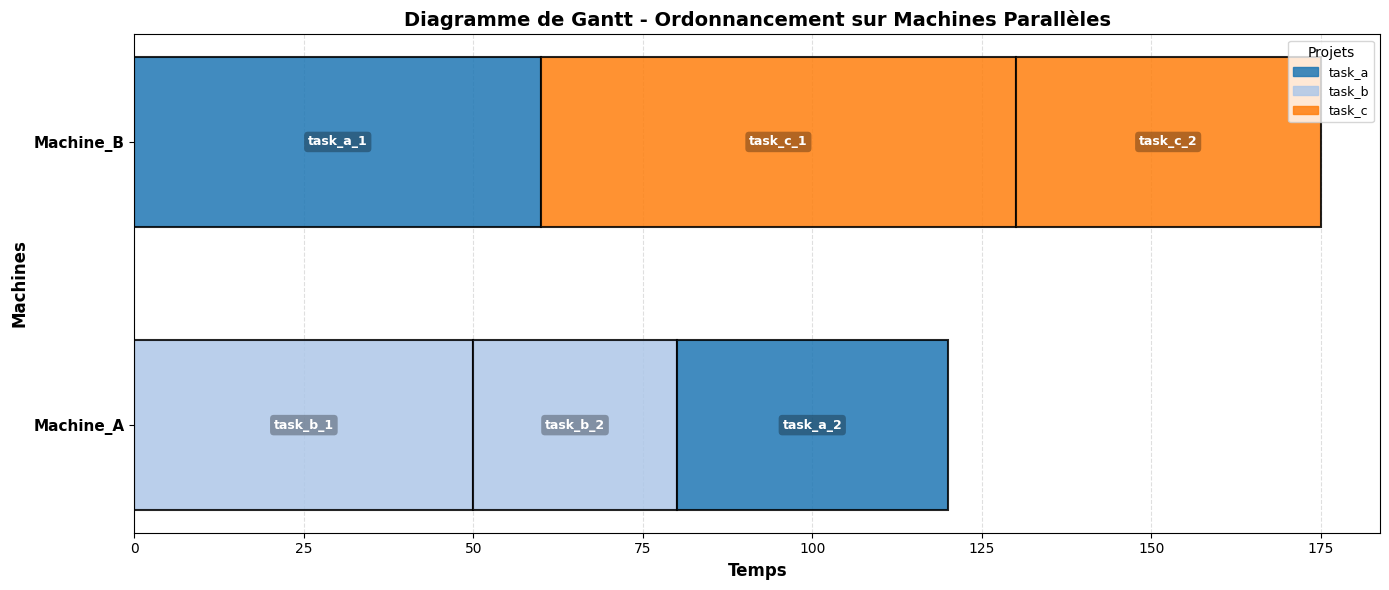

In [45]:
# ============================================
# EXEMPLE 4: Visualisation avec Données Manuelles
# ============================================

# Créer un exemple plus grand pour une meilleure visualisation
gantt_tasks = {
    # Projet A
    "task_a_1": taskInfo(duration=60, successors="task_a_2", release_date=0, due_date=300),
    "task_a_2": taskInfo(duration=40, successors="none", release_date=0, due_date=300),
    
    # Projet B
    "task_b_1": taskInfo(duration=50, successors="task_b_2", release_date=0, due_date=250),
    "task_b_2": taskInfo(duration=30, successors="none", release_date=0, due_date=250),
    
    # Projet C
    "task_c_1": taskInfo(duration=70, successors="task_c_2", release_date=0, due_date=350),
    "task_c_2": taskInfo(duration=45, successors="none", release_date=0, due_date=350),
}

gantt_machines = ["Machine_A", "Machine_B"]

# Résoudre
gantt_solver = Machine_Parallele(taskInfo, gantt_tasks, gantt_machines)

print("Ordonnancement de 6 tâches (3 projets) sur 2 machines...")
print("\n Solution trouvée!")
gantt_solver.print_machine_assignments()
gantt_solver.print_order()

print("\n" + "="*60)
print("VISUALISATION DU DIAGRAMME DE GANTT...")
print("="*60)

# Afficher le diagramme de Gantt
gantt_solver.visualize_gantt()

### Diagramme de Gantt avec Données Générées

VISUALISATION DES 3 NIVEAUX DE DIFFICULTE
Chargement depuis les fichiers CSV generes par generator.py

[1/3] Chargement de dataset_facile.csv...
Jeu de donnees charge depuis: dataset_facile.csv
Charge: 6 taches sur 4 machines
Solution trouvee pour niveau FACILE!

=== Affectation des Tâches aux Machines ===
m_1: task_c_2
m_2: task_c_1
m_3: task_a_2, task_b_2
m_4: task_a_1, task_b_1

----------------------------------------------------------------------
DIAGRAMME DE GANTT - NIVEAU FACILE
----------------------------------------------------------------------


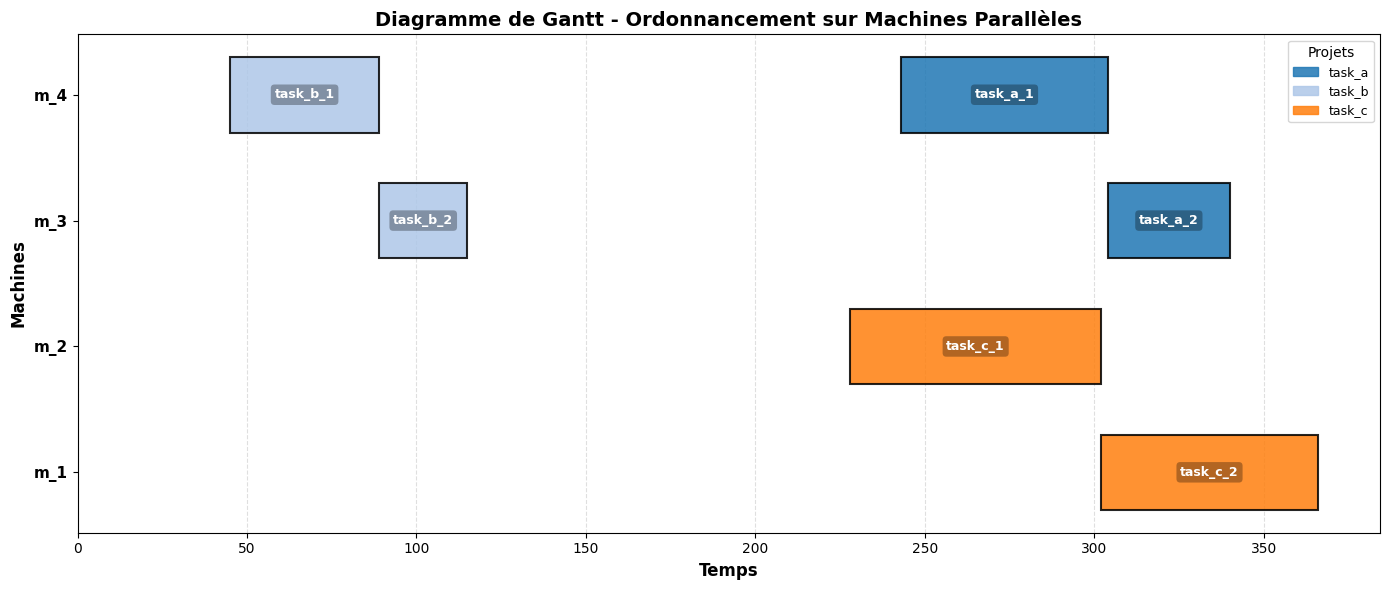



[2/3] Chargement de dataset_moyen.csv...
Jeu de donnees charge depuis: dataset_moyen.csv
Charge: 10 taches sur 3 machines
Solution trouvee pour niveau MOYEN!

=== Affectation des Tâches aux Machines ===
m_1: task_b_1, task_b_2, task_d_2, task_e_1, task_e_2
m_2: task_c_1, task_c_2, task_d_1
m_3: task_a_1, task_a_2

----------------------------------------------------------------------
DIAGRAMME DE GANTT - NIVEAU MOYEN
----------------------------------------------------------------------


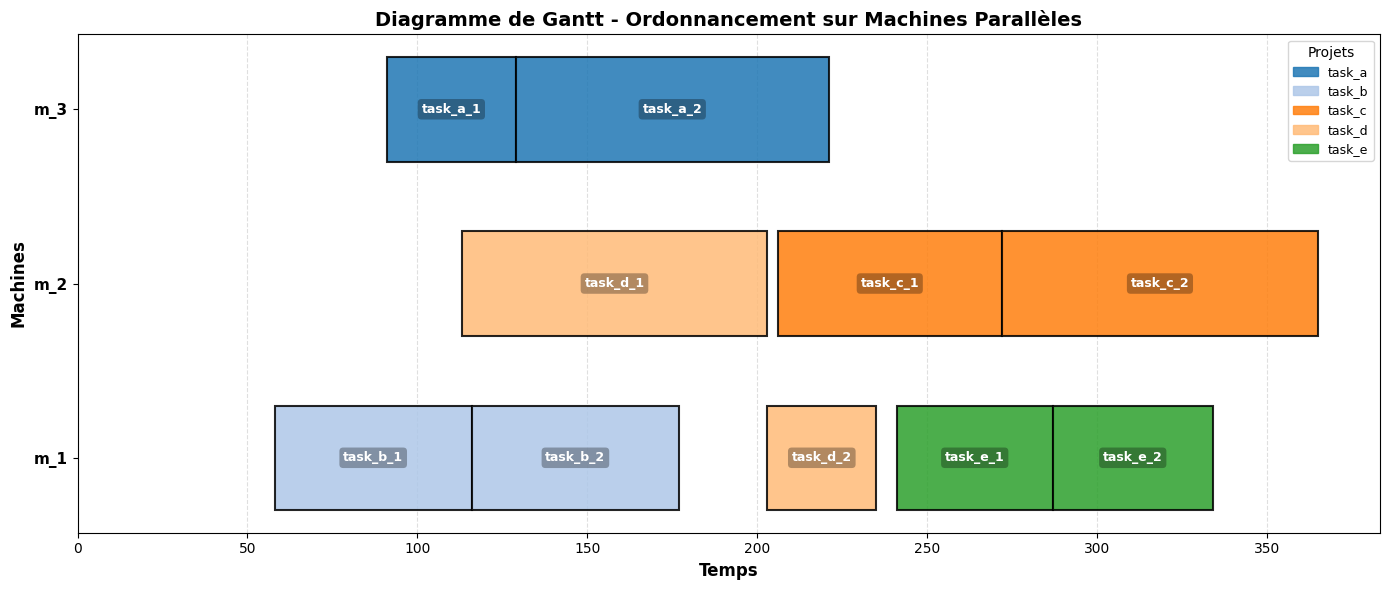



[3/3] Chargement de dataset_difficile.csv...
Jeu de donnees charge depuis: dataset_difficile.csv
Charge: 16 taches sur 10 machines
Solution trouvee pour niveau DIFFICILE!

=== Affectation des Tâches aux Machines ===
m_1: task_b_2, task_c_1, task_h_1, task_h_2
m_2: task_g_2
m_3: task_f_1, task_f_2
m_4: task_d_2, task_e_1, task_e_2
m_5: task_d_1
m_6: task_c_2
m_7: task_g_1
m_8: task_b_1
m_9: task_a_2
m_10: task_a_1

----------------------------------------------------------------------
DIAGRAMME DE GANTT - NIVEAU DIFFICILE
----------------------------------------------------------------------


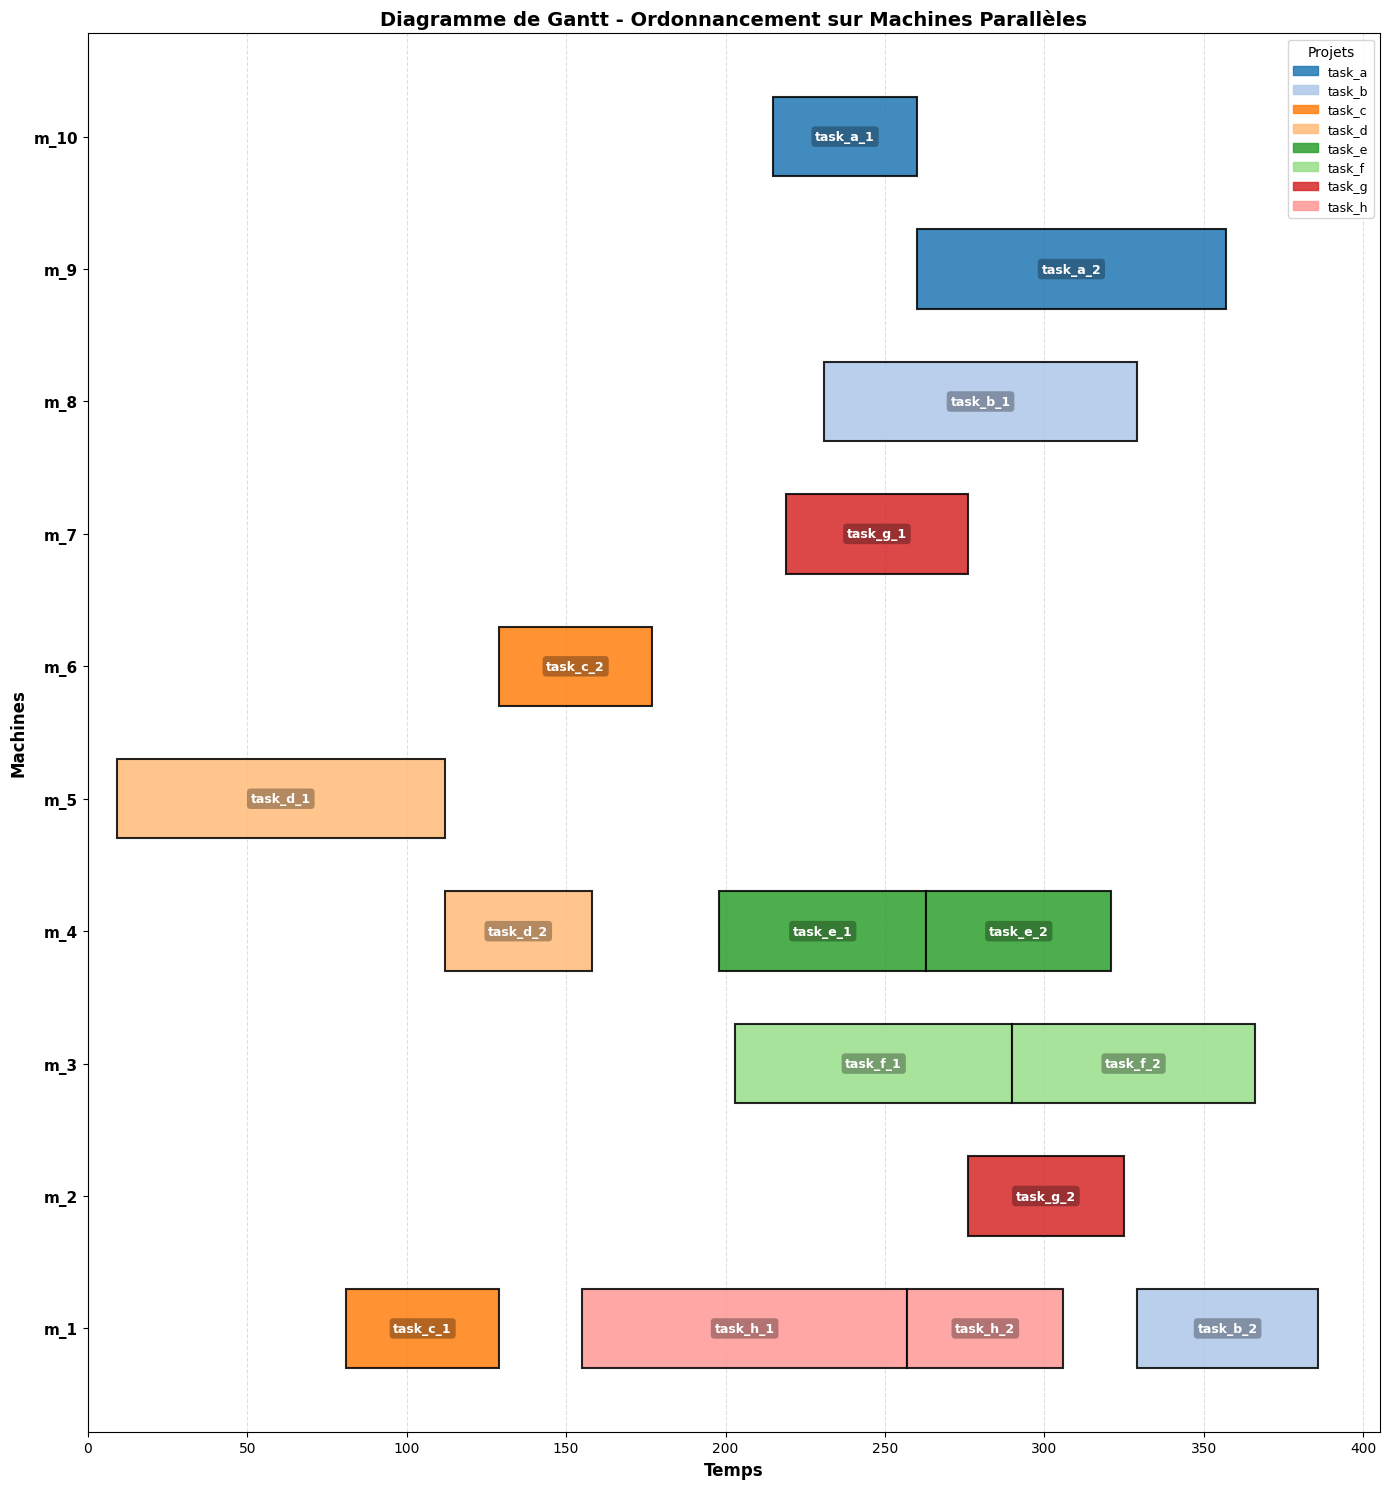


VISUALISATION TERMINEE


In [50]:
# ============================================
# EXEMPLE 5: Visualisation avec Données Générées - 3 Niveaux de Difficulté
# ============================================
# 
# Ce cell charge les datasets depuis les fichiers CSV générés par generator.py
# Pour regénérer les datasets avec des paramètres différents:
#   1. Modifiez generator.py (changez num_machines, slack_factor, etc.)
#   2. Exécutez: python generator.py
#   3. Relancez ce cell pour voir les changements dans les Gantt charts
# ============================================

from generator import SchedulingDatasetGenerator

# Créer le générateur (pour accéder à taskInfo et load_from_csv)
loader = SchedulingDatasetGenerator()

print("="*70)
print("VISUALISATION DES 3 NIVEAUX DE DIFFICULTE")
print("Chargement depuis les fichiers CSV generes par generator.py")
print("="*70)

# ============================================
# NIVEAU 1: FACILE
# ============================================
print("\n[1/3] Chargement de dataset_facile.csv...")
tasks_facile, machines_facile = loader.load_from_csv("dataset_facile.csv")
print(f"Charge: {len(tasks_facile)} taches sur {len(machines_facile)} machines")

solver_facile = Machine_Parallele(loader.taskInfo, tasks_facile, machines_facile)

if solver_facile.status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("Solution trouvee pour niveau FACILE!")
    solver_facile.print_machine_assignments()
    
    print("\n" + "-"*70)
    print("DIAGRAMME DE GANTT - NIVEAU FACILE")
    print("-"*70)
    solver_facile.visualize_gantt()
else:
    print("Aucune solution trouvee pour le niveau FACILE.")

# ============================================
# NIVEAU 2: MOYEN
# ============================================
print("\n\n[2/3] Chargement de dataset_moyen.csv...")
tasks_moyen, machines_moyen = loader.load_from_csv("dataset_moyen.csv")
print(f"Charge: {len(tasks_moyen)} taches sur {len(machines_moyen)} machines")

solver_moyen = Machine_Parallele(loader.taskInfo, tasks_moyen, machines_moyen)

if solver_moyen.status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("Solution trouvee pour niveau MOYEN!")
    solver_moyen.print_machine_assignments()
    
    print("\n" + "-"*70)
    print("DIAGRAMME DE GANTT - NIVEAU MOYEN")
    print("-"*70)
    solver_moyen.visualize_gantt()
else:
    print("Aucune solution trouvee pour le niveau MOYEN.")

# ============================================
# NIVEAU 3: DIFFICILE
# ============================================
print("\n\n[3/3] Chargement de dataset_difficile.csv...")
tasks_difficile, machines_difficile = loader.load_from_csv("dataset_difficile.csv")
print(f"Charge: {len(tasks_difficile)} taches sur {len(machines_difficile)} machines")

solver_difficile = Machine_Parallele(loader.taskInfo, tasks_difficile, machines_difficile)

if solver_difficile.status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("Solution trouvee pour niveau DIFFICILE!")
    solver_difficile.print_machine_assignments()
    
    print("\n" + "-"*70)
    print("DIAGRAMME DE GANTT - NIVEAU DIFFICILE")
    print("-"*70)
    solver_difficile.visualize_gantt()
else:
    print("Aucune solution trouvee pour le niveau DIFFICILE.")
    print("\nSi aucune solution n'est trouvee:")
    print("  - Augmentez le nombre de machines dans generator.py (DIFFICILE.num_machines)")
    print("  - Augmentez le slack_factor dans generator.py (DIFFICILE.slack_factor)")
    print("  - Reexecutez: python generator.py")
    print("  - Relancez ce cell")

print("\n" + "="*70)
print("VISUALISATION TERMINEE")
print("="*70)